points['count'] = points.apply(lambda row: points.within(row['buffer']).sum(), axis = 1)
# Data Engineering: Processing GIS data

## Shapely

[Shapely](https://shapely.readthedocs.io) is a Python library which provides data structures representing [geometric primitives](https://en.wikipedia.org/wiki/Geometric_primitive) used in GIS applications as well as methods for operations such as measurement or manipulation.

In [1]:
from shapely.geometry import Point, LineString
from shapely.ops import split

Each Shapely object has a WKT representation (accessed using the `wkt` property):

In [2]:
pt = Point((1, 1))
pt.wkt

'POINT (1 1)'

In [3]:
line = LineString([(0,0), (2,2)])
line.wkt

'LINESTRING (0 0, 2 2)'

By default, Jupyter shows shapely objects as visual renderings:

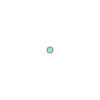

In [4]:
pt

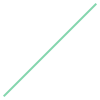

In [5]:
line

Operations include splitting of geometries, which can be useful to divide e.g. a road into segments of equal length:

LINESTRING (0 0, 2 2)
POINT (1 1)
GEOMETRYCOLLECTION (LINESTRING (0 0, 1 1), LINESTRING (1 1, 2 2))


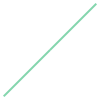

In [6]:
result = split(line, pt)
print(line)
print(pt)
print(result)
result

Points along a geometry can be used using the `interpolate` method. By default, it uses length units (without specifying what they are):

In [7]:
line.interpolate(1).wkt

'POINT (0.7071067811865475 0.7071067811865475)'

However, if you specify `normalized=True`, the number will represent the fraction (percentage) along the geometry's length:

In [8]:
line.interpolate(0.5, normalized=True).wkt

'POINT (1 1)'

## GeoPandas

[GeoPandas](https://geopandas.org/en/stable/) is a Pandas add-on that adds features useful for processing spatial data, including:

* a structure that add spatial data to Pandas DataFrames, e.g. [GeoDataFrame](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe),
* a structure that holds the spatial data itself, [GeoSeries](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geoseries), which is actually a Pandas Series with [Shapely](https://shapely.readthedocs.io) objects as values,
* [spatial operations](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html), such as measurements or trasnformations (e.g. buffering),
* [coordinate reference system (CRS)](https://geopandas.org/en/stable/docs/user_guide/projections.html) conversion and projection,
* [data import/export](https://geopandas.org/en/stable/docs/user_guide/io.html) to and from major spatial data formats using [Fiona](https://github.com/Toblerity/Fiona). 

[This *Getting Started* article](https://geopandas.org/en/stable/getting_started/introduction.html) is a good place to start.

### Input/output

First, let's import Fiona itself (normally, GeoPandas will import that for you) and check the available data I/O formats:

In [9]:
import fiona
fiona.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

Now let's import GeoPandas:

In [10]:
import geopandas as gpd

### Basic usage

We have a GeoJSON file with streetlamps in Kraków, let's import it and take a basic look at it:

In [11]:
gdf_lamps = gpd.read_file('lamps.geojson')
print("Type:", type(gdf_lamps))
print("Shape:", gdf_lamps.shape)
gdf_lamps.head()

Type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (3742, 4)


lamp_id circuit       label                   geometry
0     5907    4260  4260 III/9  POINT (19.89914 50.07404)
1     5908    4104    4104 I/7  POINT (19.89139 50.07505)
2     5909    4070    4070 I/8  POINT (19.89821 50.07306)
3     5910    4148   4148 I/14  POINT (19.88872 50.07352)
4     5911    4148    4148 I/4  POINT (19.89168 50.07328)

If you look in the actual GeoJSON file, you'll see that it doesn't have a CRS definition. What CRS is our GeoDataFrame in, then?

In [12]:
gdf_lamps.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ah, yes, it's WGS-84, because that's what is assumed, by convention, for GeoJSON. Since the coordinate values actually looked like latitude and longitude (in degrees), that's what GeoPandas assumed automatically.

### Visualisation

GeoPandas use Matplotlib for visualisation, let's do that:

<AxesSubplot: >

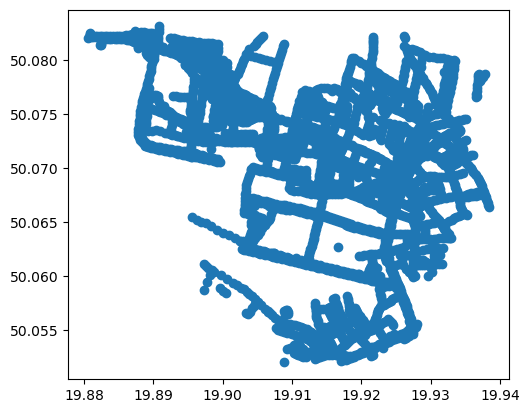

In [13]:
gdf_lamps.plot()

Note that the image isn't distorted (squashed), even though the dataset uses WGS-84. That is because GeoPandas is aware and corrects the proportions for us.

However, more context, i.e. a background map, could be useful. This can be achieved by means of the [contextily](https://contextily.readthedocs.io/en/latest/) library. Because proportions are no longer automatically corrected, we will reproject the dataset to EPSG:3857, i.e. the [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection).

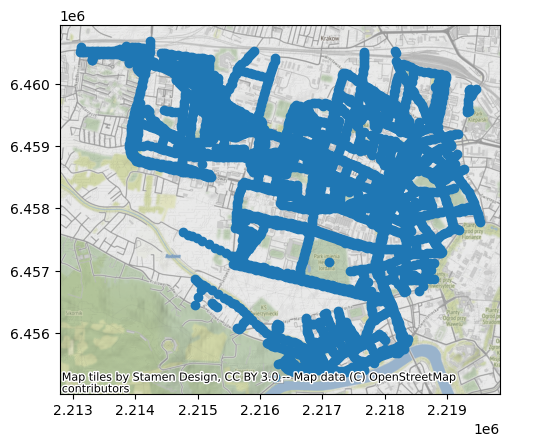

In [14]:
import contextily as cx
gdf_lamps.to_crs('epsg:3857', inplace=True)
ax = gdf_lamps.plot()
cx.add_basemap(ax, crs=gdf_lamps.crs.to_string())

An interactive map can be created by means of  e.g. [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) or [Folium](https://python-visualization.github.io/folium/).

### Coordinate reference systems

Since we will be making measurements in meters, we need to reproject our dataset into a planar (local) CRS that's appropriate for Kraków – remember that Mercator projections are not suitable for measurements, see e.g. [this website](https://www.thetruesize.com). 

For Kraków, we have several choices, and this time we'll use Zone 7 of the official [Polish CS2000](https://pl.wikipedia.org/wiki/Układ_współrzędnych_2000) reference system, which has an EPSG identifier of 2178.

In [15]:
gdf_lamps.to_crs('epsg:2178', inplace=True)
gdf_lamps.crs

<Projected CRS: EPSG:2178>
Name: ETRF2000-PL / CS2000/21
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore between 19°30'E and 22°30'E.
- bounds: (19.5, 49.09, 22.5, 54.55)
Coordinate Operation:
- name: Poland CS2000 zone 7
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Take a look at what the coordinate values look like after reprojection:

In [16]:
gdf_lamps.head()

lamp_id circuit       label                         geometry
0     5907    4260  4260 III/9  POINT (7421200.890 5549236.163)
1     5908    4104    4104 I/7  POINT (7420648.372 5549356.622)
2     5909    4070    4070 I/8  POINT (7421133.034 5549127.243)
3     5910    4148   4148 I/14  POINT (7420454.349 5549189.001)
4     5911    4148    4148 I/4  POINT (7420665.797 5549159.122)

## Getting OSM data

The dataset imported in the previous step contains points representing streetlight locations in Kraków. But we don't have any streets!

To give some context to our data, we need another dataset. A good place to look for one is [OpenStreetMap](https://www.openstreetmap.org). Technically, we can get OSM data in two ways:

* by downloading a dump of the data:
  * either the complete dataset ([Planet OSM](https://planet.openstreetmap.org)) from the official server,
  * or an extract for a given region from one of the websites that provide them, e.g. [GeoFabrik](https://download.geofabrik.de),
* by making a query to the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API), either directly or using a library that encapsulates it in a user-friendly way.

When working with OSM data, we usually only want a specific set of objects, e.g. roads that can be used by motor vehicles. Normally, this filtering is done using keys and values assigned to nodes, ways and relations. The catalogue of all possible keys and values is available at the [Map Features](https://wiki.openstreetmap.org/wiki/Map_features) page in the OSM Wiki. For instance, to only get roads, we would choose objects that have the [`highway`](https://wiki.openstreetmap.org/wiki/Map_features#Highway) tag with appropriate values. Some OSM-related libraries facilitate this by providing predefined sets of tags for various purposes.

### Importing downloaded data

OSM data can be downloaded as [OSM XML](https://wiki.openstreetmap.org/wiki/OSM_XML) files (which, being text files, can be rather big), or as [PBF Files](https://wiki.openstreetmap.org/wiki/PBF_Format). 

If the data needs to be processed before being imported (e.g. by cropping a large dataset to a desired location), you can use [Osmosis](https://wiki.openstreetmap.org/wiki/Osmosis), which is a command-line tool written in Java. Osmosis can also convert OSM XML or PBF data to other formats, see the [manual](https://wiki.openstreetmap.org/wiki/Osmosis/Detailed_Usage).

[Pyrosm](https://pyrosm.readthedocs.io/en/latest/) is a Python library that lets you import an OSM XML/PBF file to a GeoDataFrame. Actually, Pyrosm can also download data from GeoFabrik or BBBike on its own. Let's see what's available:

In [17]:
import pyrosm
print(pyrosm.data.sources.available)

{'africa': ['algeria', 'angola', 'benin', 'botswana', 'burkina_faso', 'burundi', 'cameroon', 'canary_islands', 'cape_verde', 'central_african_republic', 'chad', 'comores', 'congo_brazzaville', 'congo_democratic_republic', 'djibouti', 'egypt', 'equatorial_guinea', 'eritrea', 'ethiopia', 'gabon', 'ghana', 'guinea', 'guinea_bissau', 'ivory_coast', 'kenya', 'lesotho', 'liberia', 'libya', 'madagascar', 'malawi', 'mali', 'mauritania', 'mauritius', 'morocco', 'mozambique', 'namibia', 'niger', 'nigeria', 'rwanda', 'saint_helena_ascension_and_tristan_da_cunha', 'sao_tome_and_principe', 'senegal_and_gambia', 'seychelles', 'sierra_leone', 'somalia', 'south_africa', 'south_africa_and_lesotho', 'south_sudan', 'sudan', 'swaziland', 'tanzania', 'togo', 'tunisia', 'uganda', 'zambia', 'zimbabwe'], 'antarctica': ['antarctica'], 'asia': ['afghanistan', 'armenia', 'azerbaijan', 'bangladesh', 'bhutan', 'cambodia', 'china', 'gcc_states', 'india', 'indonesia', 'iran', 'iraq', 'israel_and_palestine', 'japan',

Let's download a dataset…

In [18]:
fp = pyrosm.get_data('cracow')
print(fp)

/var/folders/gq/26w5y9g55lqbr_33nt79r1g40000gn/T/pyrosm/Cracow.osm.pbf


…and import it:

In [19]:
osm = pyrosm.OSM(fp)
type(osm)

pyrosm.pyrosm.OSM

Pyrosm provides the `get_network` method which returns one of the predefined sets of road networks:
* `walking`,
* `cycling`,
* `driving`,
* `driving+service`,
* `all`.

Let's get the driving roads:

In [20]:
gdf_driving = osm.get_network(network_type="driving")
print(type(gdf_driving))
gdf_driving.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


access  area bicycle bridge cycleway est_width  foot footway      highway  \
0   None  None    None   None     None      None  None    None  residential   
1   None  None    None   None     None      None  None    None     tertiary   
2   None  None    None   None     None      None  None    None  residential   
3   None  None    None   None     None      None  None    None  residential   
4   None  None      no   None     None      None  None    None        trunk   

  int_ref  ... tunnel  turn width       id timestamp version  \
0    None  ...   None  None  None  2954554         0      -1   
1    None  ...   None  None  None  2954556         0      -1   
2    None  ...   None  None  None  2954557         0      -1   
3    None  ...   None  None  None  2954558         0      -1   
4    E 77  ...   None  None  None  4576181         0      -1   

                                                tags osm_type  \
0                             {"lane_markings":"no"}      way   
1                     {"source:maxspeed":"PL:urban"}      way   
2     {"noname":"yes","source:maxspeed":"PL:zone30"}      way   
3     {"noname":"yes","source:maxspeed":"PL:zone30"}      way   
4  {"highway:category:pl":"1","highway:class:pl":...      way   

                                            geometry length  
0  MULTILINESTRING ((20.03435 50.08069, 20.03451 ...  470.0  
1  MULTILINESTRING ((20.03607 50.07940, 20.03613 ...   93.0  
2  MULTILINESTRING ((20.03550 50.07981, 20.03566 ...   26.0  
3  MULTILINESTRING ((20.03485 50.08194, 20.03516 ...   83.0  
4  MULTILINESTRING ((19.80783 50.08821, 19.80718 ...  110.0  

[5 rows x 38 columns]

…and plot the data:

<AxesSubplot: >

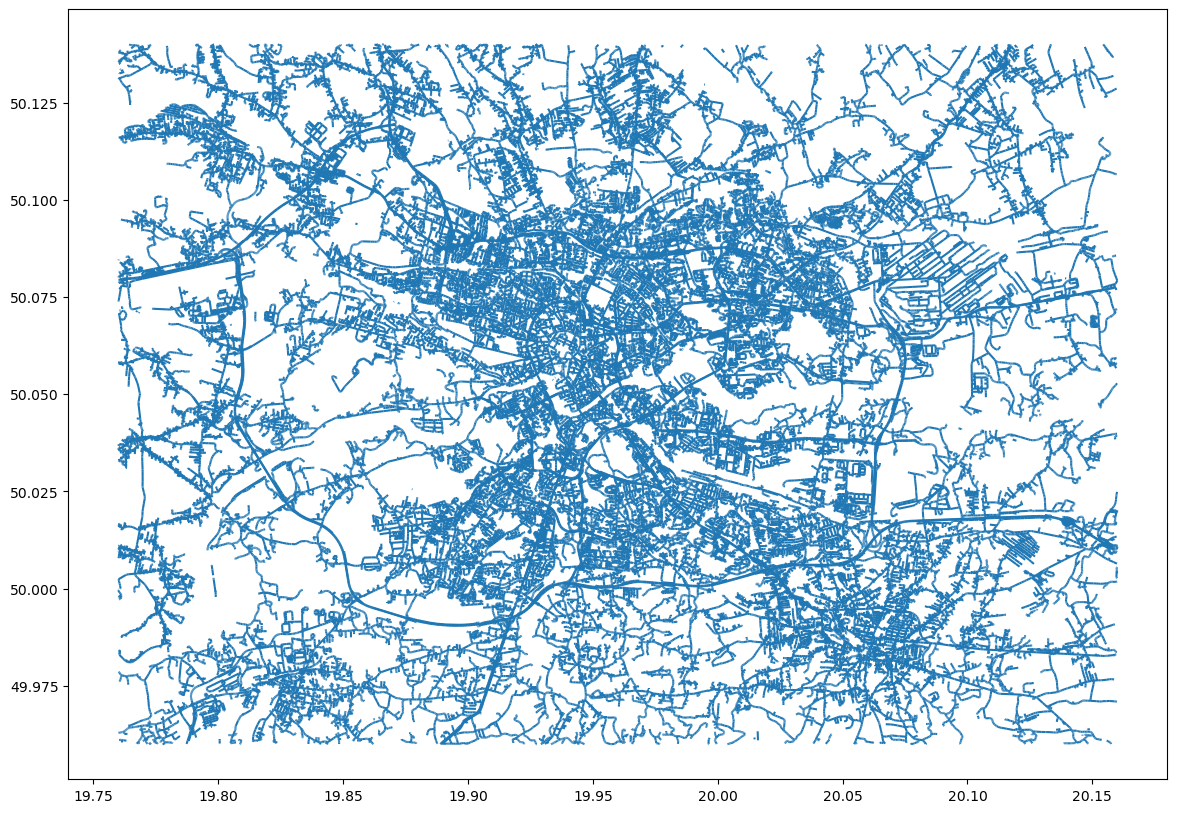

In [21]:
gdf_driving.plot(figsize=(15, 10))

Other OSM object types can be retrieved using methods such as `get_buildings`, `get_boundaries`, etc. The tags used to filter imported OSM objects can be customized using `get_data_by_custom_criteria`.

## NetworkX + OSMnx

[NetworkX](https://networkx.org) is a very popular graph processing and network analysis library for Python. 

[OSMnx](https://osmnx.readthedocs.io/) is a NetworkX add-on which provides functions to represent OSM data as NetworkX graphs, but also as GeoPandas structures. Instead of using (or downloading) XML/PBF dumps, it uses Overpass to query the servers for a given region/dataset. The data can be returned as a NetworkX graph using the `graph` module, or as GeoDataFrames using the `geometries` module.

In [22]:
import osmnx as ox

While the `graph` module has predefined sets of OSM tags representing network types, the `geometries` module needs explicit specification of OSM tags used for filtering (similarly to `get_data_by_custom_criteria` in Pyrosm). Let's do that:

In [23]:
osm_tags = {
    'highway': [
        'motorway',
        'motorway_link',
        'trunk',
        'trunk_link',
        'primary',
        'primary_link',
        'secondary',
        'secondary_link',
        'tertiary',
        'tertiary_link',
        'residential',
        'living_street',
        'service',
        'unclassified'
    ]
}

gdf_osm = ox.geometries_from_place('Krowodrza, Kraków, Poland', tags=osm_tags)
print(gdf_osm.shape)
gdf_osm.head()

(1788, 134)


bicycle foot   highway  \
element_type osmid                             
way          19801451     NaN  NaN   service   
             19801525     NaN  NaN   service   
             19801528     NaN   no  tertiary   
             19801536     NaN   no  tertiary   
             19801540     NaN   no  tertiary   

                                                                geometry  bus  \
element_type osmid                                                              
way          19801451  LINESTRING (19.89509 50.07056, 19.89521 50.070...  NaN   
             19801525  LINESTRING (19.90676 50.08216, 19.90717 50.082...  NaN   
             19801528  LINESTRING (19.91533 50.08169, 19.91535 50.08185)  NaN   
             19801536  LINESTRING (19.91535 50.08185, 19.91542 50.08221)  NaN   
             19801540  LINESTRING (19.91542 50.08221, 19.91546 50.08239)  NaN   

                             name traffic_calming check_date motor_vehicle  \
element_type osmid                                                           
way          19801451         NaN             NaN        NaN           NaN   
             19801525         NaN             NaN        NaN           NaN   
             19801528  Wrocławska             NaN        NaN           NaN   
             19801536  Wrocławska             NaN        NaN           NaN   
             19801540  Wrocławska             NaN        NaN           NaN   

                      junction  ... surface:note parking:lane:left:parallel  \
element_type osmid              ...                                           
way          19801451      NaN  ...          NaN                        NaN   
             19801525      NaN  ...          NaN                        NaN   
             19801528      NaN  ...          NaN                        NaN   
             19801536      NaN  ...          NaN                        NaN   
             19801540      NaN  ...          NaN                        NaN   

                      cutting oneway:motorcycle sidewalk:both:surface  \
element_type osmid                                                      
way          19801451     NaN               NaN                   NaN   
             19801525     NaN               NaN                   NaN   
             19801528     NaN               NaN                   NaN   
             19801536     NaN               NaN                   NaN   
             19801540     NaN               NaN                   NaN   

                      parking:lane:both:parallel  \
element_type osmid                                 
way          19801451                        NaN   
             19801525                        NaN   
             19801528                        NaN   
             19801536                        NaN   
             19801540                        NaN   

                      parking:lane:both:perpendicular  \
element_type osmid                                      
way          19801451                             NaN   
             19801525                             NaN   
             19801528                             NaN   
             19801536                             NaN   
             19801540                             NaN   

                      parking:lane:right:diagonal  \
element_type osmid                                  
way          19801451                         NaN   
             19801525                         NaN   
             19801528                         NaN   
             19801536                         NaN   
             19801540                         NaN   

                      parking:lane:left:perpendicular lines  
element_type osmid                                           
way          19801451                             NaN   NaN  
             19801525                             NaN   NaN  
             19801528                             NaN   NaN  
             19801536                             NaN   N

Let's check the CRS of the downloaded GeoDataFrame:

In [24]:
gdf_osm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

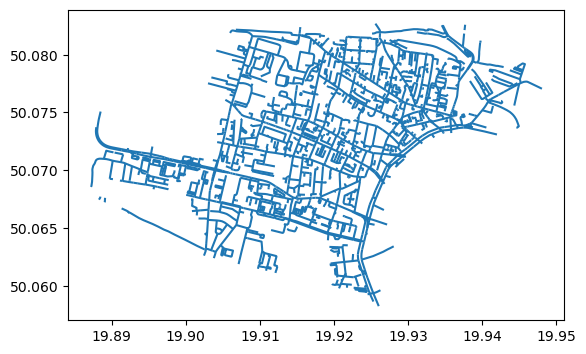

In [25]:
gdf_osm.plot()

As we can see, the GeoDataFrame is structured with a [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html), with the OSM element type (way, node, relation) at the first level and the OSM identifier at the second:

In [26]:
gdf_osm.index

MultiIndex([('way',   19801451),
            ('way',   19801525),
            ('way',   19801528),
            ('way',   19801536),
            ('way',   19801540),
            ('way',   21025095),
            ('way',   21046520),
            ('way',   21072913),
            ('way',   21094552),
            ('way',   21094558),
            ...
            ('way', 1158624635),
            ('way', 1158624636),
            ('way', 1158625085),
            ('way', 1158625574),
            ('way', 1158837320),
            ('way', 1159998255),
            ('way', 1160173344),
            ('way', 1160173345),
            ('way', 1160709530),
            ('way', 1161276224)],
           names=['element_type', 'osmid'], length=1788)

Since we're only interested in ways (e.g. linestrings), let's get that portion of the dataframe:

In [27]:
gdf_lines = gdf_osm.loc['way', :]
gdf_lines.head()

bicycle foot   highway  \
osmid                             
19801451     NaN  NaN   service   
19801525     NaN  NaN   service   
19801528     NaN   no  tertiary   
19801536     NaN   no  tertiary   
19801540     NaN   no  tertiary   

                                                   geometry  bus        name  \
osmid                                                                          
19801451  LINESTRING (19.89509 50.07056, 19.89521 50.070...  NaN         NaN   
19801525  LINESTRING (19.90676 50.08216, 19.90717 50.082...  NaN         NaN   
19801528  LINESTRING (19.91533 50.08169, 19.91535 50.08185)  NaN  Wrocławska   
19801536  LINESTRING (19.91535 50.08185, 19.91542 50.08221)  NaN  Wrocławska   
19801540  LINESTRING (19.91542 50.08221, 19.91546 50.08239)  NaN  Wrocławska   

         traffic_calming check_date motor_vehicle junction  ... surface:note  \
osmid                                                       ...                
19801451             NaN        NaN           NaN      NaN  ...          NaN   
19801525             NaN        NaN           NaN      NaN  ...          NaN   
19801528             NaN        NaN           NaN      NaN  ...          NaN   
19801536             NaN        NaN           NaN      NaN  ...          NaN   
19801540             NaN        NaN           NaN      NaN  ...          NaN   

         parking:lane:left:parallel cutting oneway:motorcycle  \
osmid                                                           
19801451                        NaN     NaN               NaN   
19801525                        NaN     NaN               NaN   
19801528                        NaN     NaN               NaN   
19801536                        NaN     NaN               NaN   
19801540                        NaN     NaN               NaN   

         sidewalk:both:surface parking:lane:both:parallel  \
osmid                                                       
19801451                   NaN                        NaN   
19801525                   NaN                        NaN   
19801528                   NaN                        NaN   
19801536                   NaN                        NaN   
19801540                   NaN                        NaN   

         parking:lane:both:perpendicular parking:lane:right:diagonal  \
osmid                                                                  
19801451                             NaN                         NaN   
19801525                             NaN                         NaN   
19801528                             NaN                         NaN   
19801536                             NaN                         NaN   
19801540                             NaN                         NaN   

         parking:lane:left:perpendicular lines  
osmid                                           
19801451                             NaN   NaN  
19801525                             NaN   NaN  
19801528                             NaN   NaN  
19801536                             NaN   NaN  
19801540                             NaN   NaN  

[5 rows x 134 columns]

Finally, let's reproject that dataset to EPSG:2178 to make it compatible with the streetlights dataset imported earlier on:

In [28]:
gdf_lines.to_crs('epsg:2178', inplace=True)
gdf_lines.head()

bicycle foot   highway  \
osmid                             
19801451     NaN  NaN   service   
19801525     NaN  NaN   service   
19801528     NaN   no  tertiary   
19801536     NaN   no  tertiary   
19801540     NaN   no  tertiary   

                                                   geometry  bus        name  \
osmid                                                                          
19801451  LINESTRING (7420905.801 5548852.957, 7420913.9...  NaN         NaN   
19801525  LINESTRING (7421759.503 5550131.243, 7421788.8...  NaN         NaN   
19801528  LINESTRING (7422372.091 5550070.051, 7422374.4...  NaN  Wrocławska   
19801536  LINESTRING (7422374.447 5550087.359, 7422379.9...  NaN  Wrocławska   
19801540  LINESTRING (7422379.904 5550127.472, 7422382.5...  NaN  Wrocławska   

         traffic_calming check_date motor_vehicle junction  ... surface:note  \
osmid                                                       ...                
19801451             NaN        NaN           NaN      NaN  ...          NaN   
19801525             NaN        NaN           NaN      NaN  ...          NaN   
19801528             NaN        NaN           NaN      NaN  ...          NaN   
19801536             NaN        NaN           NaN      NaN  ...          NaN   
19801540             NaN        NaN           NaN      NaN  ...          NaN   

         parking:lane:left:parallel cutting oneway:motorcycle  \
osmid                                                           
19801451                        NaN     NaN               NaN   
19801525                        NaN     NaN               NaN   
19801528                        NaN     NaN               NaN   
19801536                        NaN     NaN               NaN   
19801540                        NaN     NaN               NaN   

         sidewalk:both:surface parking:lane:both:parallel  \
osmid                                                       
19801451                   NaN                        NaN   
19801525                   NaN                        NaN   
19801528                   NaN                        NaN   
19801536                   NaN                        NaN   
19801540                   NaN                        NaN   

         parking:lane:both:perpendicular parking:lane:right:diagonal  \
osmid                                                                  
19801451                             NaN                         NaN   
19801525                             NaN                         NaN   
19801528                             NaN                         NaN   
19801536                             NaN                         NaN   
19801540                             NaN                         NaN   

         parking:lane:left:perpendicular lines  
osmid                                           
19801451                             NaN   NaN  
19801525                             NaN   NaN  
19801528                             NaN   NaN  
19801536                             NaN   NaN  
19801540                             NaN   NaN  

[5 rows x 134 columns]

## Spatial joins

Spatial datasets aren't usually related on the attribute level. For instance, our streetlights does not have a road identifier to indicate which road is illuminated by a given lamp.

Fortunately, GeoPandas supports [spatial joins](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) between GeoDataFrames using several spatial predicates. The set of predicates depends on the spatial index type used internally by GeoPandas. Let's see what's available:

In [29]:
gdf_lines.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

To find the roads *potentially* illuminated by every lamp, let's find roads not further than 20 meters from each one.

We don't have a “not further than” or “within distance” predicate available, but we can use a trick which involves creating a 20-metre buffer around each point and then using the “intersects” predicate.

Let's create a new column, `buffer_geom`, with the buffer's geometry:

In [30]:
gdf_lamps['buffer_geom'] = gdf_lamps.geometry.buffer(20)
gdf_lamps.head()

lamp_id circuit       label                         geometry  \
0     5907    4260  4260 III/9  POINT (7421200.890 5549236.163)   
1     5908    4104    4104 I/7  POINT (7420648.372 5549356.622)   
2     5909    4070    4070 I/8  POINT (7421133.034 5549127.243)   
3     5910    4148   4148 I/14  POINT (7420454.349 5549189.001)   
4     5911    4148    4148 I/4  POINT (7420665.797 5549159.122)   

                                         buffer_geom  
0  POLYGON ((7421220.890 5549236.163, 7421220.794...  
1  POLYGON ((7420668.372 5549356.622, 7420668.276...  
2  POLYGON ((7421153.034 5549127.243, 7421152.938...  
3  POLYGON ((7420474.349 5549189.001, 7420474.253...  
4  POLYGON ((7420685.797 5549159.122, 7420685.700...

Note that we now have two GeoSeries columns. While it's possible to have more than one, GeoDataFrame always has a single designated geometry column (`geometry`) by default. Another column can be designated using the `set_geometry` method temporarily (to make it permanent, use `inplace=True`).

Let's perform a spatial join between `gdf_lamps` (with `buffer_geom` set as the geometry) and a subset of columns from `gdf_lines`:

In [31]:
df_joins = gpd.sjoin(
    gdf_lines[['name', 'geometry']],
    gdf_lamps.set_geometry('buffer_geom')
)
print(type(df_joins))
df_joins.head()

<class 'pandas.core.frame.DataFrame'>


name  \
osmid                               
21025095   Mieczysława Karłowicza   
376694602   Karola Szymanowskiego   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   

                                               geometry_left  index_right  \
osmid                                                                       
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         3499   
376694602  LINESTRING (7422879.140 5548358.112, 7422880.1...         3499   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2495   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2494   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2493   

           lamp_id circuit        label                   geometry_right  
osmid                                                                     
21025095      9406    4078  4078 III/10  POINT (7422893.970 5548405.660)  
376694602     9406    4078  4078 III/10  POINT (7422893.970 5548405.660)  
21025095      8402    4078  4078 III/18  POINT (7422772.600 5548464.770)  
21025095      8401    4078  4078 III/17  POINT (7422778.190 5548493.780)  
21025095      8400    4078  4078 III/16  POINT (7422785.800 5548523.040)

Note that the result of an `sjoin` is a “normal” DataFrame, even though it contains Series (not GeoSeries!) with Shapely objects.

Also note that `sjoin` only keeps the geometry column from the first GeoDataFrame (this behaviour can be changed, but only one column is kept anyway). However, because `buffer_geom` was the geometry column of `gdf_lamps`, the original geometry column (called `geometry`) was kept as well. This is handy, as we can now calculate the distance for each road–lamp pair.



In [32]:
df_joins['distance'] = df_joins.apply(lambda x: x.geometry_left.distance(x.geometry_right), axis=1)
df_joins.head()

name  \
osmid                               
21025095   Mieczysława Karłowicza   
376694602   Karola Szymanowskiego   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   

                                               geometry_left  index_right  \
osmid                                                                       
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         3499   
376694602  LINESTRING (7422879.140 5548358.112, 7422880.1...         3499   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2495   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2494   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2493   

           lamp_id circuit        label                   geometry_right  \
osmid                                                                      
21025095      9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
376694602     9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
21025095      8402    4078  4078 III/18  POINT (7422772.600 5548464.770)   
21025095      8401    4078  4078 III/17  POINT (7422778.190 5548493.780)   
21025095      8400    4078  4078 III/16  POINT (7422785.800 5548523.040)   

           distance  
osmid                
21025095   5.666394  
376694602  5.518974  
21025095   4.627691  
21025095   4.619592  
21025095   5.153291

Please note that we used the `distance` method provided by Shapely objects in this example.

We could also use the `distance` method of GeoSeries, but we need to convert the columns back to GeoSeries from Series:

In [33]:
df_joins['distance2'] = gpd.GeoSeries(df_joins.geometry_left).distance(gpd.GeoSeries(df_joins.geometry_right))
df_joins.head()

name  \
osmid                               
21025095   Mieczysława Karłowicza   
376694602   Karola Szymanowskiego   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   

                                               geometry_left  index_right  \
osmid                                                                       
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         3499   
376694602  LINESTRING (7422879.140 5548358.112, 7422880.1...         3499   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2495   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2494   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2493   

           lamp_id circuit        label                   geometry_right  \
osmid                                                                      
21025095      9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
376694602     9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
21025095      8402    4078  4078 III/18  POINT (7422772.600 5548464.770)   
21025095      8401    4078  4078 III/17  POINT (7422778.190 5548493.780)   
21025095      8400    4078  4078 III/16  POINT (7422785.800 5548523.040)   

           distance  distance2  
osmid                           
21025095   5.666394   5.666394  
376694602  5.518974   5.518974  
21025095   4.627691   4.627691  
21025095   4.619592   4.619592  
21025095   5.153291   5.153291

## Saving spatial data

Finally, let's save the “joins” dataset to a geospatial data file. First, we need to convert the DataFrame to a GeoDataFrame. Note that since there's no column called `geometry`, we need to specify the geoemtry column name for it to have one. It's also a good idea to specify the CRS, as that information got lost when the GeoDataFrame was “converted” to a DataFrame by the spatial join.

In [34]:
gdf_joins = gpd.GeoDataFrame(df_joins, geometry="geometry_right", crs='epsg:2178')
gdf_joins.head()

name  \
osmid                               
21025095   Mieczysława Karłowicza   
376694602   Karola Szymanowskiego   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   
21025095   Mieczysława Karłowicza   

                                               geometry_left  index_right  \
osmid                                                                       
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         3499   
376694602  LINESTRING (7422879.140 5548358.112, 7422880.1...         3499   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2495   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2494   
21025095   LINESTRING (7422888.308 5548405.447, 7422885.9...         2493   

           lamp_id circuit        label                   geometry_right  \
osmid                                                                      
21025095      9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
376694602     9406    4078  4078 III/10  POINT (7422893.970 5548405.660)   
21025095      8402    4078  4078 III/18  POINT (7422772.600 5548464.770)   
21025095      8401    4078  4078 III/17  POINT (7422778.190 5548493.780)   
21025095      8400    4078  4078 III/16  POINT (7422785.800 5548523.040)   

           distance  distance2  
osmid                           
21025095   5.666394   5.666394  
376694602  5.518974   5.518974  
21025095   4.627691   4.627691  
21025095   4.619592   4.619592  
21025095   5.153291   5.153291

Let's save the dataset to a GeoJSON file. New versions of GeoPandas infer the driver to be used from the extension; for older versions, we would need to specify the Fiona driver explicitly:

```python
gdf_joins.to_file('joins.geojson', driver='GeoJSON')
```

Also note that each data format has some limitations regarding the acceptable data types. Because of that, we need to drop the `geometry_left` column, as Shapely objects are not directly serializable to anything acceptable by GeoJSON (we could replace the objects with their WKT representations).

In [35]:
gdf_joins.drop(columns='geometry_left', inplace=True)
gdf_joins.to_file('joins.geojson')

Take a look in the GeoJSON file and note that it now has a CRS specification at the top. It is good to have that, especially if the CRS is something else than WGS 84.

If we don't specify an extension, [ESRI Shapefile](https://en.wikipedia.org/wiki/Shapefile) will be used as the output format, and a folder will be created (as Shapefile datasets consist of more than one file):

In [36]:
gdf_joins.to_file('joins')

/var/folders/gq/26w5y9g55lqbr_33nt79r1g40000gn/T/ipykernel_47494/1506228909.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_joins.to_file('joins')


One limitation of Shapefiles is that the column names cannot be longer than 10 characters. Look how `index_right` became `index_righ`:

In [37]:
gpd.read_file('joins').columns

Index(['osmid', 'name', 'index_righ', 'lamp_id', 'circuit', 'label',
       'distance', 'distance2', 'geometry'],
      dtype='object')

Another format worth considering is [GeoPackage](https://en.wikipedia.org/wiki/GeoPackage), designed as a successor to Shapefiles. As GPKG files are, interally, extended [SQLite](https://www.sqlite.org/index.html) databases, they provide better performance than e.g. GeoJSON with tools such as [QGIS](https://www.qgis.org/). 

In [38]:
gdf_joins.to_file('joins.gpkg')

You can also browse them using SQLite tools, which makes them quite portable and versatile:

![](gpkg-sqlite.png)